In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid, make_axes_locatable, host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
from IPython.display import HTML
from io import StringIO
%matplotlib inline
# %matplotlib notebook
import warnings;
warnings.filterwarnings('ignore')

/Users/dawson29/Projects/pyPIPS/pyPIPS/PIPS.py:540: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def calc_empirical_fallspeed(d, correct_rho=False, rho=None):



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:1085: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def fit_DSD_TMM246(M2, M4, M6, D_min, D_max):
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:1170: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def fit_DSD_TMM234(M2, M3, M4, D_min, D_max):
/Users/dawson29/Projects/pyPIPS/pyPIPS/DSDlib.py:1611: NumbaDeprecatio

In [2]:
# Function definitions
def readsound(path,stype,rmqc=False):
    """Reads in a sounding from a text file and returns a pandas dataframe. Accepts various formats."""
    if(stype == 'ESC'):
        return readESC(path)
    elif(stype == 'CM1'):
        return readCM1(path)
    elif(stype == 'sharppy'):
        return readsharppy(path)
    else:
        print("Sounding type not supported")
        return
    
def readCM1(path):
    """Reads in a sounding in CM1 (or COMMAS) input sounding format"""
    col_names = ['height','potential temperature','water vapor mixing ratio','u_wind','v_wind']
    with open(path) as f:
        header = f.readline().strip().split()
    psfc = float(header[0])
    thetasfc = float(header[1])
    qvsfc = float(header[2])
    # Check whether mixing ratio is in g/kg or kg/kg and convert to kg/kg if needed
    qvscale = 1.
    if qvsfc > 0.1:
        qvscale = 1.e-3
    qvsfc = qvsfc*qvscale
    df = pd.read_csv(path, skiprows=1, names=col_names, delim_whitespace=True)
    df['water vapor mixing ratio'] = df['water vapor mixing ratio'].values*qvscale
    # Check that height is in m, in some cases it's in km and needs to be converted
    # z = df['height'].values
    # If the final height is < 100. assume that the units are km and convert to m
    if(df['height'].values[-1] < 100.):
        df['height'] = df['height'].values*1000.
    # Compute pressure
    p = compute_pressure(df['height'].values, df['potential temperature'].values, 
                         df['water vapor mixing ratio'].values, psfc, qvsfc, thetasfc)
    df['pressure'] = p
    # Compute temperature
    df['temperature'] = thermo.calT(df['pressure'].values*100., df['potential temperature'].values)-273.15
    # Compute water vapor specific humidity and dewpoint
    wv = df['water vapor mixing ratio'].values
    df['water vapor specific humidity'] = wv/(1.+wv)
    df['dewpoint'] = thermo.calTd(df['pressure'].values*100., df['water vapor specific humidity'].values)-273.15
    return df

def readESC(sounding_path, interpnan=True, handle=False):
    """
    Reads in a sounding in ESC format from a provided file path or handle (can be a StringIO object or an open
    file handle)
    """
    col_names = ['pressure','temperature','dewpoint','u_wind','v_wind','speed','direction','height',
                 'Qp_code','Qt_code','Qrh_code','Qu_code','Qv_code']
    # First read the file and extract the field widths from the 14th header line
    if not handle:
        f = open(sounding_path, 'r')
    else:
        f = sounding_path

    # Read in the header and extract some metadata from it
    dummy = f.readline()
    dummy = f.readline()
    header2 = f.readline().strip().split(':')
    # Read next header line and extract station id and wmo number from it (if it exists)
    staid_wmo_str = header2[1]
    if ' / ' in staid_wmo_str:
        staid_wmo = staid_wmo_str.strip().split(' / ')
        staid = staid_wmo[0][1:4]
        wmo = int(staid_wmo[1])
    else:
        if '. ' in staid_wmo_str:
            staid = staid_wmo_str.replace('. ', '').strip()[:4]
        else:
            staid = staid_wmo_str.strip()[:4]
            staid = staid.replace(" ", "")
        wmo = 99999
    print(staid)
    # Read the next header line and extract the location information from it
    header3 = f.readline().strip().split(':')
    location = header3[1].strip().split(',')
    print(location)
    lon = float(location[2])
    lat = float(location[3])
    elev = float(location[4])
    # Read the next header line and extract the time information from it
    header4 = f.readline().strip()[31:].lstrip()   
    sounding_datetime = datetime.strptime(header4, '%Y, %m, %d, %H:%M:%S')
    
    # Now read and dump the rest of the header
    for i in range(9):
        f.readline()
    
    # Except for the last header line, which is used to determine the widths of the fields
    line = f.readline().strip().split()
    fw = [len(field)+1 for field in line]

    # Now read the file into the dataframe, using the extracted field widths
    df = pd.read_fwf(f, usecols=[1, 2, 3, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19],
                     names=col_names, na_values=['99999.0', '9999.0', '999.0'], widths=fw)
    
    # For some reason, need to convert all the columns to floating point here, as some get interpreted as strings
    # when they shouldn't be...
    # print(df['pressure'], df['temperature'])
    for column in df.columns:
        df[column] = df[column].astype(float)
    
    # Drop rows where height or pressure is NaN. TODO: Can't remember why I have to use reset_index(drop=True). 
    # Figure this out.
    df = df.dropna(subset=('height', 'pressure')).reset_index(drop=True)
    # Set the height as the index so we can use it as weights to interpolate other columns across NaN
    df = df.set_index('height')
    df['height'] = df.index
    
    if interpnan:
        # First convert direction and speed to u, v components
        df['u'], df['v'] = mpcalc.wind_components(df['speed'].values*units('m/s'),
                                                      df['direction'].values*units.degrees)
        # Now interpolate
        df = df.interpolate(method='values')
        # Finally recompute direction and speed from u, v components
        df['speed'] = mpcalc.wind_speed(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
        df['direction'] = mpcalc.wind_direction(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
    else:
        # Drop any rows with all NaN values for T, Td, winds
        df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                               'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    
    df = df[(df.Qp_code == 1.0) & (df.Qt_code == 1.0) & (df.Qrh_code == 1.0) & (df.Qu_code == 1.0) & 
            (df.Qv_code == 1.0)]

    nlines = df.count()['pressure']
    
    if not handle:
        f.close()
    
    snd_metadata = {
        'sounding_datetime': sounding_datetime,
        'lat': lat,
        'lon': lon,
        'selev': elev,
        'staid': staid,
        'wmo': wmo,
        'nlevs': nlines,
        'staid_long': staid_wmo_str
    }
    
    return snd_metadata, df


def readsharppy(path):
    """Reads in a sounding in sharppy format"""
        ## read in the file
    f = open(path, 'r')
    lines = f.read()
    data = np.array([l.strip() for l in lines.split('\n')])
    f.close()

    ## necessary index points
    title_idx = np.where( data == '%TITLE%')[0][0]
    start_idx = np.where( data == '%RAW%' )[0][0] + 1
    finish_idx = np.where( data == '%END%')[0][0]
    
    ## create the plot title
    data_header = data[title_idx + 1].split()
    location = data_header[0]
    time = data_header[1][:11]

    ## put it all together for StringIO
    full_data = '\n'.join(data[start_idx : finish_idx][:])
    sound_data = StringIO( full_data )

    ## read the data into arrays
    p, h, T, Td, wdir, wspd = np.genfromtxt( sound_data, delimiter=',', comments="%", unpack=True )
    
    col_names = ['pressure','height','temperature','dewpoint','speed','direction']
    data_dict = {key:value for (key,value) in zip(col_names,[p,h,T,Td,wspd,wdir])}
    
    df = pd.DataFrame.from_dict(data_dict)
    
    return df


def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)


def rain_Brandes(D):
    """Given a range of diameters D, compute rain fall speed curve, a quartic polynomial
       fit after Brandes et al. (2002)."""
    
    D_mm=D*1000. # get it to (mm)
    
    Vtr = -0.1021 + 4.932*D_mm - 0.9551*D_mm**2. + 0.07934*D_mm**3. - 0.002362*D_mm**4.
    
    return Vtr


def cal_xf_tf(usm, vsm, vt, H, perturb_vt=False, sigma=0.1):
    """Computes final horizontal position and residence time (relative to starting position) of a raindrop
       falling through a horizontally homogeneous layer H with terminal velocity vt and 
       storm releative mean wind given by (usm, vsm)."""
    
    if perturb_vt:
        rng = np.random.default_rng()
        vt_perts = sigma * rng.standard_normal(vt.size)
        vt = vt + vt_perts
    
    tf = H / vt
    xf = tf * usm
    yf = tf * vsm
    
    return xf, yf, tf


def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val

def interp_pyart_grid_to_PIPS(grid_ds, PIPS_loc_list):
    """Interpolate pyart gridded radar to PIPS locations given an xarray dataset with pyart grid info and a list
       of PIPS lats, lons, and altitudes. Returns lists of PIPS x, y, and z locations in radar grid coordinates
       and a list of xarray Datasets for each grid variable interpolated to each PIPS location."""

    # TODO: instead of returning lists, maybe make the PIPS name a dimension of a new xarray Dataset
    
    ctrlat = float(grid_ds.origin_latitude)
    ctrlon = float(grid_ds.origin_longitude)
    print(ctrlat, ctrlon)

    radar_at_PIPS_list = []
    PIPS_x_list = []
    PIPS_y_list = []
    PIPS_z_list = []

    for PIPS_loc in PIPS_locs:
        PIPS_lat = PIPS_loc[0]
        PIPS_lon = PIPS_loc[1]
        PIPS_alt = PIPS_loc[2]
        radar_alt = float(grid_ds.origin_altitude)
        
        PIPS_z = PIPS_alt - radar_alt
        PIPS_z_list.append(PIPS_z)
        # Use this function to get the x and y coords of the PIPS. Note that this will only be correct 
        # if the radar
        # grid was created using the default pyart aeqd projection.
        PIPS_x, PIPS_y = pyart.core.geographic_to_cartesian_aeqd(PIPS_lon, PIPS_lat, ctrlon, ctrlat)
        PIPS_x = PIPS_x.squeeze().item()
        PIPS_y = PIPS_y.squeeze().item()
        PIPS_x_list.append(PIPS_x)
        PIPS_y_list.append(PIPS_y)
        print('PIPS lat, lon, alt: ', PIPS_lat, PIPS_lon, PIPS_alt)
        print('PIPS x, y, z: ', PIPS_x, PIPS_y, PIPS_z)
        radar_at_PIPS_ds = grid_ds.interp(x=PIPS_x, y=PIPS_y)
        radar_at_PIPS_list.append(radar_at_PIPS_ds)

    return PIPS_x_list, PIPS_y_list, PIPS_z_list, radar_at_PIPS_list

# DTD: modified from pyart to use gate edges instead of centers
def get_gate_area(radarobj, sweep, edges=True):
    """
    Return the area of each gate in a sweep. Units of area will be the 
    same as those of the range variable, squared.

    Assumptions:
        1. Azimuth data is in degrees.

    Parameters
    ----------
    sweep : int
        Sweep number to retrieve gate locations from, 0 based.

    Returns
    -------
    area : 2D array of size (ngates - 1, nrays - 1)
        Array containing the area (in m * m) of each gate in the sweep.

    """
    s = radarobj.get_slice(sweep)
    azimuths = radarobj.azimuth['data'][s]
    ranges = radarobj.range['data']
    if edges:
        azimuths = pyart.core.transforms._interpolate_azimuth_edges(azimuths)
        ranges = pyart.core.transforms._interpolate_range_edges(ranges)
        
    circular_area = np.pi * ranges ** 2
    annular_area = np.diff(circular_area)

    d_azimuths = np.diff(azimuths) / 360. # Fraction of a full circle
    # The following fixes the problem where the azimuths are differenced across 0/360 degs
    d_azimuths = np.where(d_azimuths < 0., d_azimuths + 1., d_azimuths)

    dca, daz = np.meshgrid(annular_area,d_azimuths)

    area = np.abs(dca * daz)
    return area

In [3]:
# Read in the radar data
radar_name = 'KGWX'
radar_type= 'NEXRAD'
elev_angle = 0.5
elev_str = str(elev_angle).replace('.', 'p')
elev_tol = 0.1

date = '0330'
radar_start_datetimestamp = '20220330233252' # '20220330220424'
radar_end_datetimestamp = '20220331011617' # '20220331035633'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_datetimestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_datetimestamp, '%Y%m%d%H%M%S')

radar_basedir = \
    '/Users/dawson29/Projects/PERiLS/obsdata/2022/NEXRAD/IOP2/KGWX'
#radar_basedir = os.path.join(radar_basedir, '{}/{}'.format(date, radar_name[1:]))
radar_input_dir = os.path.join(radar_basedir, 'extracted_sweeps')
radar_output_dir = os.path.join(radar_basedir, 'extracted_sweeps')
if not os.path.exists(radar_output_dir):
    os.makedirs(radar_output_dir)

radar_start_timestamp = datetime_start.strftime('%Y%m%d%H%M')
radar_end_timestamp = datetime_end.strftime('%Y%m%d%H%M')

radar_paths = glob.glob(radar_input_dir + f'/{radar_name}*el{elev_str}_filt_retr.nc')

radar_paths = sorted(radar_paths)
radar_input_list = []

for path in radar_paths:
    filename = os.path.basename(path)
    file_timestamp = filename[4:19]
    # print(file_timestamp)
    file_datetime = datetime.strptime(file_timestamp, '%Y%m%d_%H%M%S')
    if file_datetime >= datetime_start and file_datetime <= datetime_end:
        radar_input_list.append(path)

# Read in the individual sweeps
radarobj_list = []
for radar_path in radar_input_list:
    print(f"Reading {os.path.basename(radar_path)}")
    radarobj = pyart.io.read(radar_path)
    radarobj_list.append(radarobj)

Reading KGWX20220330_233252_el0p5_filt_retr.nc
Reading KGWX20220330_233335_el0p5_filt_retr.nc
Reading KGWX20220330_233419_el0p5_filt_retr.nc
Reading KGWX20220330_233502_el0p5_filt_retr.nc
Reading KGWX20220330_233952_el0p5_filt_retr.nc
Reading KGWX20220330_234033_el0p5_filt_retr.nc
Reading KGWX20220330_234114_el0p5_filt_retr.nc
Reading KGWX20220330_234155_el0p5_filt_retr.nc
Reading KGWX20220330_234639_el0p5_filt_retr.nc
Reading KGWX20220330_234720_el0p5_filt_retr.nc
Reading KGWX20220330_234801_el0p5_filt_retr.nc
Reading KGWX20220330_234842_el0p5_filt_retr.nc
Reading KGWX20220330_235324_el0p5_filt_retr.nc
Reading KGWX20220330_235403_el0p5_filt_retr.nc
Reading KGWX20220330_235442_el0p5_filt_retr.nc
Reading KGWX20220330_235521_el0p5_filt_retr.nc
Reading KGWX20220330_235959_el0p5_filt_retr.nc
Reading KGWX20220331_000037_el0p5_filt_retr.nc
Reading KGWX20220331_000114_el0p5_filt_retr.nc
Reading KGWX20220331_000152_el0p5_filt_retr.nc
Reading KGWX20220331_000624_el0p5_filt_retr.nc
Reading KGWX2

In [4]:
plot_dir = os.path.join(radar_output_dir, 'plots')
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
# Read in PIPS data (just to get lat/lon for now)
deployment = 'IOP2_033022'
PIPS_list = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
PIPS_data_dir = '/Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf'

PIPS_ds_list = []
PIPS_locs = []

for PIPS in PIPS_list:
    PIPS_filename = 'parsivel_combined_{}_{}_60s.nc'.format(deployment, PIPS)
    PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
    PIPS_ds = xr.load_dataset(PIPS_filepath)
    PIPS_ds_list.append(PIPS_ds)
    PIPS_loc = eval(PIPS_ds.location)
    PIPS_locs.append(PIPS_loc)


In [6]:
for PIPS_ds in PIPS_ds_list:
    print(PIPS_ds["{}_beam_height_at_PIPS".format(radar_name)].mean())

<xarray.DataArray 'KGWX_beam_height_at_PIPS' ()>
array(287.13914248)
<xarray.DataArray 'KGWX_beam_height_at_PIPS' ()>
array(337.87090405)
<xarray.DataArray 'KGWX_beam_height_at_PIPS' ()>
array(234.62174135)
<xarray.DataArray 'KGWX_beam_height_at_PIPS' ()>
array(203.40872638)


In [7]:
# Read in sounding file to get low-level wind field and then derive storm-relative wind
# Storm motion taken from subjective reflectivity tag tracking using GRLevel2
# EDIT: don't need storm motion because it is implicitly handled in time-dependent trajectory model
# ustorm = 12.51
# vstorm = 12.95

# EDIT: setting ustorm, vstorm to 0 to force ground-relative flow
ustorm = 0.
vstorm = 0.

# For 04/30 case
# sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/soundings/COMP5mb'
# sounding_filename = 'Hollywood_201704301954.cls'

# For 03/27 case
# sounding_dir = '/Users/dawson29/Projects/plotsnd/notebooks/'
# sounding_filename = '201703272100_3469_8600.sharppy'

# For 03/25 case 
# sounding_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/2017/soundings/'
# sounding_filename = 'Courtland_1759.txt'

# sounding_path = os.path.join(sounding_dir, sounding_filename)

# For 04/30 case
# sounding_metadata, sounding_df = readESC(sounding_path)

# For PERiLS IOP2 UIUC SONDE4
sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/PERiLS/obsdata/2022/non-radar_QC_Illinois/20220330_IOP02/SONDE4/sounding/L2'
sounding_filename = 'SPC_20220330_SONDE4_2328.txt'
sounding_path = os.path.join(sounding_dir, sounding_filename)

sounding_df = readsharppy(sounding_path)
wind_dir = sounding_df['direction'].values*units.degrees
print(wind_dir)
wind_speed_kts = sounding_df['speed'].values*units.knots 
wind_speed_ms = wind_speed_kts.to(units('m/s'))
print(wind_speed_ms)
u, v = wind_components(wind_speed_ms, wind_dir)
print(u, v)

# For 03/27 case
#sounding_df = readsharppy(sounding_path)
#wind_dir = sounding_df['direction'].values*units.degrees
#print(wind_dir)
#wind_speed_kts = sounding_df['speed'].values*units.knots 
#wind_speed_ms = wind_speed_kts.to(units('m/s'))
#print(wind_speed_ms)
#u, v = wind_components(wind_speed_ms, wind_dir)
#print(u, v)

[169.98 169.99 170.0 169.99 169.99 170.02 170.01 170.01 170.01 170.0 169.99 170.0 169.99 169.98 169.97 170.02 170.02 170.01 170.01 170.01 170.0 170.0 169.99 169.99 170.0 170.03 170.02 170.01 169.97 169.97 169.95 169.94 169.95 170.01 170.16 170.39 170.62 170.79 170.92 171.0 170.98 170.96 170.94 170.96 171.03 171.21 171.46 171.69 171.86 171.97 172.02 172.03 172.0 171.99 171.96 171.97 172.09 172.29 172.62 172.85 172.96 173.01 173.04 173.03 173.04 173.05 173.02 172.92 172.67 172.38 172.16 172.02 171.97 171.97 171.98 172.01 172.01 172.01 172.01 172.0 172.0 172.0 172.01 171.98 171.97 171.94 171.99 172.15 172.44 172.75 173.05 173.38 173.68 173.92 174.14 174.4 174.68 174.88 175.0 175.2 175.48 175.77 175.95 176.01 176.02 176.02 176.01 176.02 176.04 176.05 176.0 175.81 175.5 175.22 175.06 174.99 174.98 174.97 174.99 175.0 175.0 174.99 175.0 175.0 175.0 174.99 175.0 175.0 175.01 174.99 175.0 175.0 175.01 175.0 175.0 175.0 175.01 175.0 175.0 175.0 175.0 175.0 175.0 174.98 174.96 174.95 174.97 175.

In [8]:
# Find PIPS x, y location relative to radar by interpolating to its lat/lon point

rlat = radarobj_list[0].latitude['data'][0]
rlon = radarobj_list[0].longitude['data'][0]
ralt = radarobj_list[0].altitude['data'][0]

PIPS_x_list = []
PIPS_y_list = []
PIPS_z_list = []

for PIPS_ds in PIPS_ds_list:
    geo_loc_str = PIPS_ds.location
    geo_loc = list(map(float, geo_loc_str.strip('()').split(',')))
    rad_loc = radar.get_PIPS_loc_relative_to_radar(geo_loc, rlat, rlon, ralt)
    PIPS_x_list.append(rad_loc[0])
    PIPS_y_list.append(rad_loc[1])
    PIPS_z_list.append(rad_loc[2])
    
PIPS_z_mean = np.array(PIPS_z_list).mean()
print(PIPS_z_list)
print(PIPS_z_mean)
PIPS_x_arr = np.array(PIPS_x_list)
PIPS_y_arr = np.array(PIPS_y_list)

print(PIPS_x_arr, PIPS_y_arr)

Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.75801086325083 -88.44616666666666 70.7434820494946
PIPS location relative to radar (x, y, z) -10813.806115689142 -15439.327656729798 -108.2565179505054
Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.71500000000001 -88.45050000000002 66.61888437828897
PIPS location relative to radar (x, y, z) -11220.039260227966 -20221.4503250962 -112.38111562171103
Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.82966666666666 -88.45933333333333 73.6733731892389
PIPS location relative to radar (x, y, z) -12020.943833369885 -7470.109111668025 -105.3266268107611
Radar location (lat, lon, alt) 33.896915435791016 -88.32919311523438 179.0
Disdrometer location (lat, lon, alt) 33.829666666666654 -88.45933333333333 104.94753711996229
PIPS location relative to radar

In [9]:
# Extract within a small bounding box and for a limited time slice

# For 04/30 case
# tstart = '2017-04-30T20:00'
# tstop = '2017-04-30T21:30'

# For 03/27 case
# tstart = '2017-03-27T19:30'
# tstop = '2017-03-27T21:00'

# For 03/25 case
# tstart = '2017-03-25T17:05'
# tstop = '2017-03-25T18:35'

# For PERiLS IOP2 2022 case
tstart = '2022-03-30T23:30'
tstop = '2022-03-31T01:15'

# Create datetime objects for start and end times
datetime_tstart = datetime.strptime(tstart, '%Y-%m-%dT%H:%M')
datetime_tend = datetime.strptime(tstop, '%Y-%m-%dT%H:%M')

# Exclude data beyond a given range
max_range = 100000.
gate_range = radarobj_list[0].range['data']
gate_range_2D = np.tile(gate_range, (radarobj_list[0].nrays, 1))
print(gate_range_2D)

radarobj_sublist = []
radarpath_sublist = []
for path, radarobj in zip(radar_input_list, radarobj_list):
    filename = os.path.basename(path)
    file_timestamp = filename[4:19]
    # print(file_timestamp)
    file_datetime = datetime.strptime(file_timestamp, '%Y%m%d_%H%M%S')
    if file_datetime >= datetime_tstart and file_datetime <= datetime_tend:
        print(os.path.basename(path))
        radarpath_sublist.append(path)
        for field in radarobj.fields:
            gate_range = radarobj.range['data']
            gate_range_2D = np.tile(gate_range, (radarobj.nrays, 1))
            # print(gate_range_2D)
            radarobj.fields[field]['data'] = np.ma.masked_where(gate_range_2D > max_range, 
                                                                radarobj.fields[field]['data'])
        radarobj_sublist.append(radarobj)

[[  2125.   2375.   2625. ... 459375. 459625. 459875.]
 [  2125.   2375.   2625. ... 459375. 459625. 459875.]
 [  2125.   2375.   2625. ... 459375. 459625. 459875.]
 ...
 [  2125.   2375.   2625. ... 459375. 459625. 459875.]
 [  2125.   2375.   2625. ... 459375. 459625. 459875.]
 [  2125.   2375.   2625. ... 459375. 459625. 459875.]]
KGWX20220330_233252_el0p5_filt_retr.nc
KGWX20220330_233335_el0p5_filt_retr.nc
KGWX20220330_233419_el0p5_filt_retr.nc
KGWX20220330_233502_el0p5_filt_retr.nc
KGWX20220330_233952_el0p5_filt_retr.nc
KGWX20220330_234033_el0p5_filt_retr.nc
KGWX20220330_234114_el0p5_filt_retr.nc
KGWX20220330_234155_el0p5_filt_retr.nc
KGWX20220330_234639_el0p5_filt_retr.nc
KGWX20220330_234720_el0p5_filt_retr.nc
KGWX20220330_234801_el0p5_filt_retr.nc
KGWX20220330_234842_el0p5_filt_retr.nc
KGWX20220330_235324_el0p5_filt_retr.nc
KGWX20220330_235403_el0p5_filt_retr.nc
KGWX20220330_235442_el0p5_filt_retr.nc
KGWX20220330_235521_el0p5_filt_retr.nc
KGWX20220330_235959_el0p5_filt_retr.nc
K

In [10]:
ref_varname = 'REF'
zdr_varname = 'ZDR'

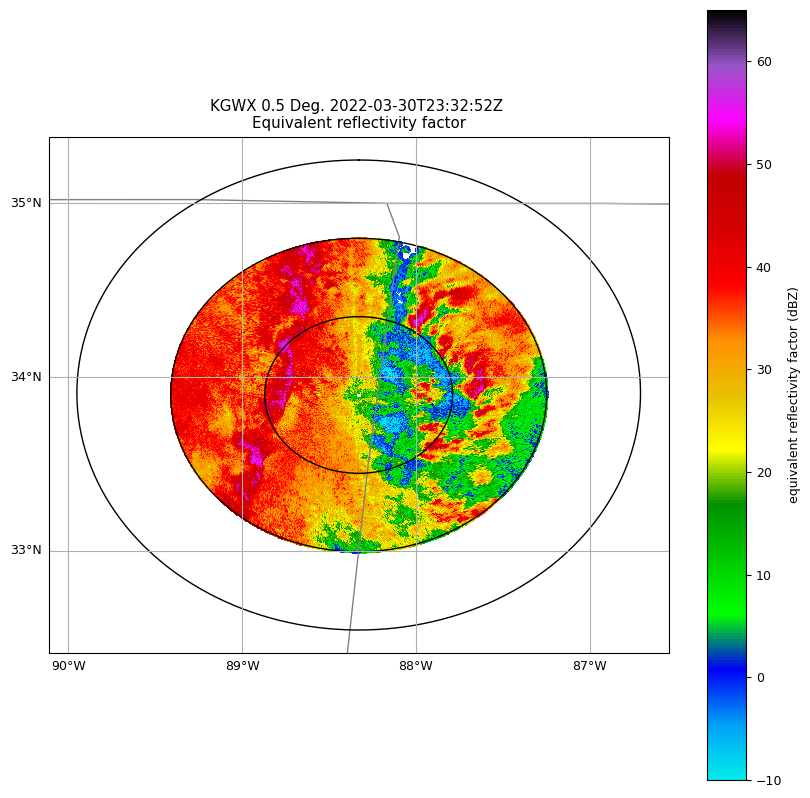

In [11]:
radarobj = radarobj_sublist[0]
ppi_display = pyart.graph.RadarMapDisplay(radarobj)
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=[10, 10], subplot_kw={'projection': projection})
ppi_display.plot_ppi_map(field='REF', sweep=0, vmin=-10, vmax = 65, cmap='pyart_NWSRef', ax=ax)
ppi_display.plot_range_rings([50, 100, 150], lw=1)

In [12]:
# Calculate ND for each grid point from gamma dist. parameters using Parsivel bins
use_parsivel_bins = True
bin_width = 0.1
retr_suffix = 'Z01_4dB'

p_avg_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
p_min_diameters = pp.parsivel_parameters['min_diameter_bins_mm']
p_max_diameters = pp.parsivel_parameters['max_diameter_bins_mm']

if use_parsivel_bins:
    avg_diameters = p_avg_diameters
    min_diameters = p_min_diameters
    max_diameters = p_max_diameters
else:
    min_diameters = np.arange(p_min_diameters[0], p_max_diameters[-1], bin_width)
    max_diameters = min_diameters + bin_width
    avg_diameters = 0.5*(min_diameters + max_diameters)

avg_diameters = xr.DataArray(avg_diameters, coords = {'diameter': ('diameter_bin', avg_diameters)}, 
                             dims=['diameter_bin'])


# Loop through the radar sweeps and create xarray DataArrays for each sweep time. Add to lists and then
# concatenate the lists into a single DataArray along the time dimension

# TODO: can probably simplify this if the gates don't change across times...
gate_x_xr_list = []
gate_y_xr_list = []
gate_z_xr_list = []
gate_area_xr_list = []
lamda_xr_list = []
alpha_xr_list = []
N0_xr_list = []

max_range_index = 392 # index of range beyond 100000. m

for radarobj in radarobj_sublist:
    sweep_time = pyart.graph.common.generate_radar_time_sweep(radarobj, 0)
    print("Processing for ", sweep_time)
    # Get the x, y, and z coordinates of the gates
    gate_x, gate_y, gate_z = radarobj.get_gate_x_y_z(0)
    
    new_range = radarobj.range['data'][None, :max_range_index+1]

    gate_x = gate_x[:, :max_range_index+1]
    gate_y = gate_y[:, :max_range_index+1]
    gate_z = gate_z[:, :max_range_index+1]
    
    
#     gate_x_xr = xr.DataArray(gate_x[None, ...], coords = {'time': ('time', [sweep_time]),
#                                                           'azimuth': ('azimuth', radarobj.azimuth['data']),
#                                                           'range': ('range', radarobj.range['data'])},
#                              dims=['time', 'azimuth', 'range'])
    
    gate_x_xr = xr.DataArray(gate_x[None, ...], 
                             coords = {'time': ('time', [sweep_time]),
                                       'azimuth_cor': (('time', 'azimuth'), radarobj.azimuth['data'][None, ...]),
                                       'range_cor': (('time', 'range'), new_range)},
                             dims=['time', 'azimuth', 'range'])
    
    gate_y_xr = xr.DataArray(gate_y[None, ...], 
                             coords = {'time': ('time', [sweep_time]),
                                       'azimuth_cor': (('time', 'azimuth'), radarobj.azimuth['data'][None, ...]),
                                       'range_cor': (('time', 'range'), new_range)},
                             dims=['time', 'azimuth', 'range'])
    gate_z_xr = xr.DataArray(gate_z[None, ...], 
                             coords = {'time': ('time', [sweep_time]),
                                       'azimuth_cor': (('time', 'azimuth'), radarobj.azimuth['data'][None, ...]),
                                       'range_cor': (('time', 'range'), new_range)},
                             dims=['time', 'azimuth', 'range'])

    # Also get area of each gate. We'll need it later
    gate_area = get_gate_area(radarobj, 0)
    
    gate_area = gate_area[:, :max_range_index+1]

    gate_area_xr = xr.DataArray(gate_area[None, ...], 
                             coords = {'time': ('time', [sweep_time]),
                                       'azimuth_cor': (('time', 'azimuth'), radarobj.azimuth['data'][None, ...]),
                                       'range_cor': (('time', 'range'), new_range)},
                             dims=['time', 'azimuth', 'range'])


    lamda = radarobj.fields[f'lamda_{retr_suffix}']['data'] * 1000. # get to m^-1
    alpha = radarobj.fields[f'mu_{retr_suffix}']['data']
    N0 = radarobj.fields[f'N0_{retr_suffix}']['data'] * 1000**(1 + alpha) # get to m^-4
    
    lamda = lamda[:, :max_range_index+1]
    alpha = alpha[:, :max_range_index+1]
    N0 = N0[:, :max_range_index+1]

    lamda_xr = xr.DataArray(lamda[None, ...], coords = {'time': ('time', [sweep_time]),
                                                        'y': (('azimuth', 'range'), gate_y_xr.squeeze().data),
                                                        'x': (('azimuth', 'range'), gate_x_xr.squeeze().data)},
                            dims=['time', 'azimuth', 'range'])
    alpha_xr = xr.DataArray(alpha[None, ...], coords = {'time': ('time', [sweep_time]),
                                                        'y': (('azimuth', 'range'), gate_y_xr.squeeze().data),
                                                        'x': (('azimuth', 'range'), gate_x_xr.squeeze().data)},
                            dims=['time', 'azimuth', 'range'])

    N0_xr = xr.DataArray(N0[None, ...], coords = {'time': ('time', [sweep_time]),
                                                  'y': (('azimuth', 'range'), gate_y_xr.squeeze().data),
                                                  'x': (('azimuth', 'range'), gate_x_xr.squeeze().data)},
                         dims=['time', 'azimuth', 'range'])

    gate_x_xr_list.append(gate_x_xr)
    gate_y_xr_list.append(gate_y_xr)
    gate_z_xr_list.append(gate_z_xr)
    gate_area_xr_list.append(gate_area_xr)
    lamda_xr_list.append(lamda_xr)
    alpha_xr_list.append(alpha_xr)
    N0_xr_list.append(N0_xr)
    

# Concatenate above lists
gate_x_xr_full = xr.concat(gate_x_xr_list, dim='time')
gate_y_xr_full = xr.concat(gate_y_xr_list, dim='time')
gate_z_xr_full = xr.concat(gate_z_xr_list, dim='time')
gate_area_xr_full = xr.concat(gate_area_xr_list, dim='time')
lamda_xr_full = xr.concat(lamda_xr_list, dim='time')
alpha_xr_full = xr.concat(alpha_xr_list, dim='time')
N0_xr_full = xr.concat(N0_xr_list, dim='time')

Processing for  2022-03-30 23:32:52
Processing for  2022-03-30 23:34:19
Processing for  2022-03-30 23:35:59
Processing for  2022-03-30 23:37:53
Processing for  2022-03-30 23:39:52
Processing for  2022-03-30 23:41:14
Processing for  2022-03-30 23:43:03
Processing for  2022-03-30 23:44:41
Processing for  2022-03-30 23:46:39
Processing for  2022-03-30 23:48:01
Processing for  2022-03-30 23:49:50
Processing for  2022-03-30 23:51:28
Processing for  2022-03-30 23:53:24
Processing for  2022-03-30 23:54:42
Processing for  2022-03-30 23:56:27
Processing for  2022-03-30 23:58:04
Processing for  2022-03-30 23:59:59
Processing for  2022-03-31 00:01:14
Processing for  2022-03-31 00:02:56
Processing for  2022-03-31 00:04:31
Processing for  2022-03-31 00:06:24
Processing for  2022-03-31 00:07:42
Processing for  2022-03-31 00:09:28
Processing for  2022-03-31 00:11:04
Processing for  2022-03-31 00:12:59
Processing for  2022-03-31 00:14:14
Processing for  2022-03-31 00:15:56
Processing for  2022-03-31 0

In [13]:
ND = dsd.calc_binned_DSD_from_params(N0_xr_full, lamda_xr_full, 
                                     alpha_xr_full, avg_diameters) * 1.e-3 # Get to m^-3 mm^-1
ND.coords['max_diameter'] = ('diameter_bin', max_diameters)
ND.coords['min_diameter'] = ('diameter_bin', min_diameters)
# Add time_seconds coordinate to ND, representing the number of seconds since the first sweep
# For the gridded data, this was done in the advect_correct_and_interp notebook, but since we aren't doing 
# that for this workflow (yet) we need to do it here.
time_seconds = (ND['time'] - ND['time'][0]) / np.timedelta64(1, 's')
print(time_seconds)
ND.coords['time_seconds'] = ('time', time_seconds.data)

<xarray.DataArray 'time' (time: 64)>
array([   0.,   87.,  187.,  301.,  420.,  502.,  611.,  709.,  827.,
        909., 1018., 1116., 1232., 1310., 1415., 1512., 1627., 1702.,
       1804., 1899., 2012., 2090., 2196., 2292., 2407., 2482., 2584.,
       2679., 2868., 2940., 3038., 3131., 3243., 3322., 3427., 3523.,
       3638., 3713., 3815., 3910., 4023., 4098., 4200., 4295., 4408.,
       4489., 4599., 4697., 4814., 4885., 4984., 5077., 5189., 5261.,
       5360., 5453., 5565., 5637., 5736., 5829., 5941., 6013., 6112.,
       6205.])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-30T23:32:52 ... 2022-03-31T01:16:17


In [14]:
# Now interpolate to regular 60-s time intervals using nearest-neighbor interpolation
new_times = xr.date_range(tstart, tstop, freq='60S')
ND = ND.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})
time_seconds = (ND['time'] - ND['time'][0]) / np.timedelta64(1, 's')
print(time_seconds)
ND.coords['time_seconds'] = ('time', time_seconds.data)

<xarray.DataArray 'time' (time: 106)>
array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200., 1260., 1320., 1380., 1440., 1500., 1560.,
       1620., 1680., 1740., 1800., 1860., 1920., 1980., 2040., 2100.,
       2160., 2220., 2280., 2340., 2400., 2460., 2520., 2580., 2640.,
       2700., 2760., 2820., 2880., 2940., 3000., 3060., 3120., 3180.,
       3240., 3300., 3360., 3420., 3480., 3540., 3600., 3660., 3720.,
       3780., 3840., 3900., 3960., 4020., 4080., 4140., 4200., 4260.,
       4320., 4380., 4440., 4500., 4560., 4620., 4680., 4740., 4800.,
       4860., 4920., 4980., 5040., 5100., 5160., 5220., 5280., 5340.,
       5400., 5460., 5520., 5580., 5640., 5700., 5760., 5820., 5880.,
       5940., 6000., 6060., 6120., 6180., 6240., 6300.])
Coordinates:
  * time     (time) datetime64[ns] 2022-03-30T23:30:00 ... 2022-03-31T01:15:00


In [15]:
ND

<xarray.DataArray (time: 106, azimuth: 720, range: 393, diameter_bin: 32)>
array([[[[1.10591645e-005, 4.61869651e-002, 1.12692552e+000, ...,
          7.83491351e-068, 1.95623241e-078, 3.16931977e-091],
         [8.78460658e-006, 3.66876105e-002, 8.95148762e-001, ...,
          6.22349302e-068, 1.55389064e-078, 2.51748018e-091],
         [8.78460658e-006, 3.66876105e-002, 8.95148762e-001, ...,
          6.22349302e-068, 1.55389064e-078, 2.51748018e-091],
         ...,
         [3.50895987e-001, 2.14334991e+000, 3.94683760e+000, ...,
          1.64631031e-024, 3.78162964e-028, 1.56813515e-032],
         [7.23799276e-001, 2.54491890e+000, 3.74930044e+000, ...,
          1.94135804e-021, 1.46815149e-024, 2.56910847e-028],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[8.96703708e-002, 1.31566246e+000, 3.44758380e+000, ...,
          1.29263543e-029, 4.29346919e-034, 1.72130470e-039],
         [3.06942541e-003, 4.00328665e-001, 2.51050042e+000, ...,
          3.71062899e-043, 7.66719374e-050, 6.65482451e-058],
         [4.81556396e-003, 4.72571326e-001, 2.64689792e+000, ...,
          2.57327449e-041, 1.05402279e-047, 2.09028078e-055],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[4.31262874e-006, 1.01506172e-001, 4.79915586e+000, ...,
          2.97510663e-081, 4.52232742e-094, 1.55704203e-109],
         [4.31262874e-006, 1.01506172e-001, 4.79915586e+000, ...,
          2.97510663e-081, 4.52232742e-094, 1.55704203e-109],
         [7.66905890e-006, 1.80506335e-001, 8.53424006e+000, ...,
          5.29057087e-081, 8.04196174e-094, 2.76885578e-109],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
    y             (time, azimuth, range) float32 -1.766e+03 ... 3.377e+04
    x             (time, azimuth, range) float32 1.182e+03 ... -9.424e+04
    diameter      (diameter_bin) float64 0.0625 0.1875 0.3125 ... 19.0 21.5 24.5
    max_diameter  (diameter_bin) float64 0.125 0.25 0.375 0.5 ... 20.0 23.0 26.0
    min_diameter  (diameter_bin) float64 0.0 0.125 0.25 0.375 ... 18.0 20.0 23.0
    time_seconds  (time) float64 0.0 60.0 120.0 ... 6.18e+03 6.24e+03 6.3e+03
  * time          (time) datetime64[ns] 2022-03-30T23:30:00 ... 2022-03-31T01...
Dimensions without coordinates: azimuth, range, diameter_bin

In [16]:
gate_x_xr_full = gate_x_xr_full.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})
gate_y_xr_full = gate_y_xr_full.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})
gate_z_xr_full = gate_z_xr_full.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})
gate_area_xr_full = gate_area_xr_full.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})
lamda_xr_full = lamda_xr_full.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})
alpha_xr_full = alpha_xr_full.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})
N0_xr_full = N0_xr_full.interp(time=new_times, method='nearest', kwargs={'fill_value': 'extrapolate'})

In [17]:
radar_ds = ND.to_dataset(name='ND').copy()
radar_ds['gate_x'] = gate_x_xr_full
radar_ds['gate_y'] = gate_y_xr_full
radar_ds['gate_z'] = gate_z_xr_full
radar_ds['gate_area'] = gate_area_xr_full
radar_ds['lamda'] = lamda_xr_full
radar_ds['alpha'] = alpha_xr_full
radar_ds['N0'] = N0_xr_full

In [18]:
radar_ds

<xarray.Dataset>
Dimensions:       (time: 106, azimuth: 720, range: 393, diameter_bin: 32)
Coordinates:
    y             (time, azimuth, range) float32 -1.766e+03 ... 3.377e+04
    x             (time, azimuth, range) float32 1.182e+03 ... -9.424e+04
    diameter      (diameter_bin) float64 0.0625 0.1875 0.3125 ... 19.0 21.5 24.5
    max_diameter  (diameter_bin) float64 0.125 0.25 0.375 0.5 ... 20.0 23.0 26.0
    min_diameter  (diameter_bin) float64 0.0 0.125 0.25 0.375 ... 18.0 20.0 23.0
    time_seconds  (time) float64 0.0 60.0 120.0 ... 6.18e+03 6.24e+03 6.3e+03
  * time          (time) datetime64[ns] 2022-03-30T23:30:00 ... 2022-03-31T01...
    azimuth_cor   (time, azimuth) float32 146.2 146.8 147.2 ... 289.2 289.7
    range_cor     (time, range) float32 2.125e+03 2.375e+03 ... 1.001e+05
Dimensions without coordinates: azimuth, range, diameter_bin
Data variables:
    ND            (time, azimuth, range, diameter_bin) float64 1.106e-05 ... nan
    gate_x        (time, azimuth, range) float32 1.182e+03 ... -9.424e+04
    gate_y        (time, azimuth, range) float32 -1.766e+03 ... 3.377e+04
    gate_z        (time, azimuth, range) float32 19.0 21.0 ... 1.434e+03
    gate_area     (time, azimuth, range) float32 5.095e+03 ... 2.076e+05
    lamda         (time, azimuth, range) float64 1.02e+04 1.02e+04 ... nan nan
    alpha         (time, azimuth, range) float64 8.749 8.749 8.749 ... nan nan
    N0            (time, azimuth, range) float64 1.268e+35 1.007e+35 ... nan nan

In [19]:
# Dump to file 

radar_ds.attrs['sorting_layer_top_elev'] = elev_angle

tstart_datetime = datetime.strptime(tstart, '%Y-%m-%dT%H:%M')
tstop_datetime = datetime.strptime(tstop, '%Y-%m-%dT%H:%M')

tstart_out = tstart_datetime.strftime('%Y%m%d%H%M')
tstop_out = tstop_datetime.strftime('%Y%m%d%H%M')

radar_DSD_filename = '{}_{}_{}_el{}_radar_DSDs.nc'.format(radar_name, tstart_out, tstop_out, elev_str)
print(radar_DSD_filename)
radar_DSD_path = os.path.join(radar_output_dir, radar_DSD_filename)
print(radar_DSD_path)
radar_ds.to_netcdf(radar_DSD_path)

KGWX_202203302330_202203310115_el0p5_radar_DSDs.nc
/Users/dawson29/Projects/PERiLS/obsdata/2022/NEXRAD/IOP2/KGWX/extracted_sweeps/KGWX_202203302330_202203310115_el0p5_radar_DSDs.nc


In [ ]:
x_plt = gate_x_xr_full[0]
y_plt = gate_y_xr_full[0]
area_plt = gate_area_xr_full[0]

fig, ax = plt.subplots(figsize=(10,10))
ci = ax.pcolormesh(x_plt, y_plt, area_plt, cmap='plasma')
cbarintv = 1.
cbarlevels = ticker.MultipleLocator(base=cbarintv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ci, orientation='vertical', cax=cax)
# fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
cax.set_ylabel('ratio')

In [ ]:
#print(gate_z_xr_full[0].sel(range_cor=100000., method='nearest'))
temp = gate_z_xr_full[0, 0].set_xindex('range_cor')
np.where(temp.range_cor>=100000.)

In [ ]:
# COPIED FROM PREVIOUS PRECIP_TRAJ SCRIPT
# Set up grid for precip trajectories
# TODO: need to reconcile fact that elevation of sounding site, PIPS sites, *and* radar site are not generally
# the same. For now, just take into account the difference in elevations between the PIPS and radar and assume
# sounding is at same elevation as average elevation of PIPS

# For 04/30 case (FIX THIS to be more general, but we are using ESC format for 04/30, and sharppy for 03/27)
# height_AGL_snd = sounding_df['height'] - sounding_metadata['selev']
# For 03/27 case
# height_AGL_snd = sounding_df['height']
# print(gridded_radar_subgrid['x'])

# For PERiLS IOP2 2022 case
height_AGL_snd = sounding_df['height']
print(height_AGL_snd)
# Subtract mean height difference of PIPS relative to the radar from the radar beam heights 
# (relative to the radar) to get radar beam height relative to the (average of) the PIPS altitudes
beam_height = gate_z_xr_full - PIPS_z_mean

# print(beam_height)
# print(beam_height[0].dropna(dim='azimuth'))
# print(beam_height[1].dropna(dim='azimuth'))
# Compute the layer mean winds between the mean PIPS altitude and the radar beam for each gate
# First set an appropriate max height for the wind profile. Use the beam height above PIPS at 100 km range
# rounded to nearest m
max_height = np.around(beam_height[0, 0].set_xindex('range_cor').sel(range_cor=100000., method='nearest'))
print(max_height)
# Create a range of heights at 1-m grid spacing. Probably overkill, but oh well
dz = 1.
new_heights = np.arange(0., max_height + dz, dz)

# Interpolate sounding u, v to new regularly spaced heights
# For 04/30 case (FIXME)
# u_snd = sounding_df['u'].values
# For 03/27 case/PERiLS IOP2
u_snd = u
f = interpolate.interp1d(height_AGL_snd, u_snd, bounds_error=False, fill_value=(u_snd[0], u_snd[-1]))
ug = f(new_heights)

# For 04/30 case (FIXME)
# v_snd = sounding_df['v'].values
# For 03/27 case / PERiLS IOP2
v_snd = v
f = interpolate.interp1d(height_AGL_snd, v_snd, bounds_error=False, fill_value=(v_snd[0], v_snd[-1]))
vg = f(new_heights)

# Layer mean wind below radar gate for each gate
# First get an array representing the index of each height in new_heights closest to and just above
# the beam height for each gate. Use np.searchsorted for this
beam_height_indices = np.searchsorted(new_heights, beam_height)
print(beam_height_indices.shape)
# Then use these indices to compute the mean wind components up to each height for each gate
# Based on https://stackoverflow.com/questions/65778535/average-of-a-3d-numpy-slice-based-on-2d-arrays?rq=3

# This way is very memory intensive since it is trying to do it for all spatial points for all times all at
# once. So, I modified it to iterate through each time individually and then concatenate everything at the end

# height_indices = np.arange(new_heights.shape[0])[:, None, None, None]
# print(height_indices.shape)
# print(ug.shape)

# ugm = np.where((height_indices < beam_height_indices), ug[:, None, None, None], 0).sum(0) / beam_height_indices
# vgm = np.where((height_indices < beam_height_indices), vg[:, None, None, None], 0).sum(0) / beam_height_indices

height_indices = np.arange(new_heights.shape[0])[:, None, None]
print(height_indices.shape)

ugm_list = []
vgm_list = []

for t, beam_height_indices_1t in enumerate(beam_height_indices):
    print("Working on time ", t)
    ugm_1t = np.where((height_indices < beam_height_indices_1t), 
                      ug[:, None, None], 0).sum(0) / beam_height_indices_1t
    vgm_1t = np.where((height_indices < beam_height_indices_1t), 
                      vg[:, None, None], 0).sum(0) / beam_height_indices_1t

    ugm_list.append(ugm_1t)
    vgm_list.append(vgm_1t)

ugm = np.array(ugm_list)
vgm = np.array(vgm_list)
    

# # # Storm-relative winds
# # usr = ug - ustorm
# # vsr = vg - vstorm

# # # Layer-mean storm-relative winds
# # usm = np.mean(usr)
# # vsm = np.mean(vsr)
# # print(usm, vsm)

In [ ]:
# Truncate diameter range to less than 9 mm
D_max = 9.
D_range_full = ND['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_range)
ND_trunc = ND.isel(diameter_bin=slice(0, D_max_ind))

# Compute range of terminal velocities from Brandes relation
vt_range = rain_Brandes(D_range / 1000.)
print(vt_range)

# Set dimensions back from lat/lon to y/x for ND_trunc
# ND_trunc = ND_trunc.swap_dims({'lon': 'x', 'lat': 'y'})
ND_trunc = ND_trunc.swap_dims({'time': 'time_seconds'})


# Interpolate ND to a finer grid
# Set up grid of locations
x_coords = ND_trunc['x']
y_coords = ND_trunc['y']
t_coords = ND_trunc['time_seconds']

refinement_factor = 4
time_refinement_factor = 1

# new_x_coords = np.linspace(x_coords.x[0], x_coords.x[-1], (x_coords.sizes['x'] - 1) * refinement_factor + 1)
# new_y_coords = np.linspace(y_coords.y[0], y_coords.y[-1], (y_coords.sizes['y'] - 1) * refinement_factor + 1)
# new_t_coords = np.linspace(t_coords.time_seconds[0], t_coords.time_seconds[-1], 
#                            (t_coords.sizes['time_seconds'] - 1) * time_refinement_factor + 1)

new_x_coords = x_coords
new_y_coords = y_coords
new_t_coords = t_coords


# ND_trunc = ND_trunc.interp(x=new_x_coords, y=new_y_coords, time_seconds=new_t_coords)

x_grid, y_grid, t_grid = xr.broadcast(ND_trunc['x'], ND_trunc['y'], ND_trunc['time_seconds'])

x_flat = x_grid.stack(loc=['time_seconds', 'azimuth', 'range']).values
y_flat = y_grid.stack(loc=['time_seconds', 'azimuth', 'range']).values
t_flat = t_grid.stack(loc=['time_seconds', 'azimuth', 'range']).values

# Compute horizontal deviations of drops and residence time at bottom of layer for each grid point and drop size
# TODO: Generalize this for spatially varying velocity field. Would require a numerical trajectory integration
# TODO: Update this to perturb the terminal velocities for all grid points (already modified the function above)

# Modified to loop through individual times to save memory

# xf, yf, tf = cal_xf_tf(ugm[None, ...], vgm[None, ...], vt_range[:, None, None], beam_height.values[None, ...])
# xf, yf, tf = cal_xf_tf(ugm[:, :, :, None], vgm[:, :, :, None], vt_range[None, None, None, :], 
#                        beam_height.values[:, :, :, None])

xf_list = []
yf_list = []
tf_list = []

for t, ugm_1t, vgm_1t, beam_height_1t in zip(range(len(t_coords)), ugm, vgm, beam_height.values):
    print("Working on time ", t)
    xf_1t, yf_1t, tf_1t = cal_xf_tf(ugm_1t[:, :, None], vgm_1t[:, :, None], vt_range[None, None, :], 
                                    beam_height_1t[:, :, None])
    xf_list.append(xf_1t)
    yf_list.append(yf_1t)
    tf_list.append(tf_1t)

xf = np.array(xf_list)
yf = np.array(yf_list)
tf = np.array(tf_list)

print(xf.shape)

# Do some reshaping to get everyting to line up properly
# xf = np.array([xf] * len(t_coords))
xf = xf.reshape(-1, xf.shape[-1])
# yf = np.array([yf] * len(t_coords))
yf = yf.reshape(-1, yf.shape[-1])
# tf = np.array([tf] * len(t_coords))
tf = tf.reshape(-1, tf.shape[-1])

x_flat_f = x_flat[:, np.newaxis] + xf
y_flat_f = y_flat[:, np.newaxis] + yf

# Create array of times corresponding to each initial time for trajectory endpoints as a function of diameter
t_flat_f = t_flat[:, np.newaxis] + tf

x_flat_f = x_flat_f.T
y_flat_f = y_flat_f.T
t_flat_f = t_flat_f.T

# Perturb the endpoints a bit in space and time
xpertscale = 20. # m
tpertscale = 1. # s
rng = np.random.default_rng()
xpert = xpertscale * rng.standard_normal(size=x_flat_f.shape)
ypert = xpertscale * rng.standard_normal(size=y_flat_f.shape)
tpert = tpertscale * rng.standard_normal(size=t_flat_f.shape)

xpert = np.where(xpert < -10.*xpertscale, 0., xpert)
xpert = np.where(xpert > 10.*xpertscale, 0., xpert)
ypert = np.where(ypert < -10.*xpertscale, 0., ypert)
ypert = np.where(ypert > 10.*xpertscale, 0., ypert)
tpert = np.where(tpert < -10.*tpertscale, 0., tpert)
tpert = np.where(tpert > 10.*tpertscale, 0., tpert)

# x_flat_f = x_flat_f + xpert
# y_flat_f = y_flat_f + ypert
# t_flat_f = t_flat_f + tpert

ND_trunc = ND_trunc.transpose('diameter_bin', 'time_seconds', 'azimuth', 'range')
print(x_flat_f.shape, y_flat_f.shape, t_flat_f.shape)

In [ ]:
print(len(t_coords))
print(x_coords)

In [ ]:
print(xf.shape)

ntimes = len(t_coords)
nazim = len(x_coords['azimuth'])
nrange = len(x_coords['range'])
print(ntimes, nazim, nrange)

print(xf.reshape((ntimes, nazim, nrange, -1)).shape)

xf_thin = xf.reshape((ntimes, nazim, nrange, -1))[0]
yf_thin = yf.reshape((ntimes, nazim, nrange, -1))[0]

print(xf_thin.shape)

xf_thin = xf_thin[::5, ::5, :]
yf_thin = yf_thin[::5, ::5, :]

print(xf_thin.shape)

xf_thin = xf_thin.reshape(-1, xf_thin.shape[-1])
yf_thin = yf_thin.reshape(-1, yf_thin.shape[-1])

print(xf_thin.shape)

In [ ]:
x_grid

In [ ]:
# Test plot of endpoints

x_grid_plt = x_grid.sel(time_seconds=0.)
y_grid_plt = y_grid.sel(time_seconds=0.)

x_grid_plt = x_grid_plt.thin(indexers=5)
y_grid_plt = y_grid_plt.thin(indexers=5)

x_flat_plt = x_grid_plt.stack(loc=['azimuth', 'range']).values
y_flat_plt = y_grid_plt.stack(loc=['azimuth', 'range']).values

print(x_flat_plt.shape)

# Compute horizontal deviations of drops and residence time at bottom of layer for each grid point and drop size
# TODO: Generalize this for spatially varying velocity field. Would require a numerical trajectory integration
# TODO: Update this to perturb the terminal velocities for all grid points (already modified the function above)
x_flat_f_plt = x_flat_plt[:, np.newaxis] + xf_thin
y_flat_f_plt = y_flat_plt[:, np.newaxis] + yf_thin

print(x_flat_f_plt.shape)

Nt = ND_trunc.sel(time_seconds=0.).sum(dim='diameter_bin')
Nt = Nt.thin(indexers=5)
print(Nt)
Nt_flat = Nt.values.flatten()
indices = np.where(Nt_flat > 0.)[0]
# indices = indices[::100]

print(ND_trunc['diameter'].values)

x_flat_f_0 = x_flat_f_plt[:, 8]
y_flat_f_0 = y_flat_f_plt[:, 8]
x_flat_f_1 = x_flat_f_plt[:, 16]
y_flat_f_1 = y_flat_f_plt[:, 16]

# gridded_radar_subgrid_2 = gridded_radar_subgrid.swap_dims({'time': 'time_seconds'})

radarobj = radarobj_sublist[0]

var_to_plot = radarobj.fields[f'{ref_varname}_filtered']['data']
# var_to_plot = vgm

# print(ugm.shape)
xplt, yplt, zplt = radarobj.get_gate_x_y_z(0, edges=True)


# var_da = gridded_radar_subgrid_2[f'{zdr_varname}_masked'].sel(time_seconds=0.)
# xplt = gridded_radar_subgrid_2.coords["x"]
# yplt = gridded_radar_subgrid_2.coords["y"]
# print(xplt[0], xplt[-1], yplt[0], yplt[-1])

clevels =np.arange(0., 4., 0.1)
norm = cm.colors.Normalize(vmin=0., vmax=4.)
fig, ax = plt.subplots(figsize=(10,10))
print(xplt.shape, yplt.shape, var_to_plot.shape)
# ci = ax.contourf(xplt, yplt, var_da.squeeze(), levels=clevels, cmap='plasma', norm=norm)
ci = ax.pcolormesh(xplt, yplt, var_to_plot, cmap='pyart_NWSRef')
ax.scatter(x_flat_plt[indices], y_flat_plt[indices], marker='*', color='k', label='Initial points', alpha=0.5)
ax.scatter(x_flat_f_0[indices], y_flat_f_0[indices], marker='x', color='b', label='Endpoint (D = 1 mm)', alpha=0.5)
ax.scatter(x_flat_f_1[indices], y_flat_f_1[indices], marker='o', color='g', label='Endpoint (D = 3.25 mm)', alpha=0.5)

cbarintv = 1.
cbarlevels = ticker.MultipleLocator(base=cbarintv)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
cax.set_ylabel('dB')

# ax.set_xlim(-26000., -16000.)
# ax.set_ylim(-40000., -30000.)
# ax.set_xlim(80000., 120000.)
# ax.set_ylim(60000., 100000.)
# ax.set_xlim(-20000., 0.)
# ax.set_ylim(-20000., 0.)

ax.set_xlim(-50000., 50000.)
ax.set_ylim(-50000., 50000.)

formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.legend()
ax.set_aspect('equal')

plot_filename = 'trajectory_endpoint_example.png'
plot_filepath = os.path.join(plot_dir, plot_filename)
fig.savefig(plot_filepath, dpi=300, bbox_inches='tight')

In [ ]:
# Set up 3D bins (2 for space, 1 for time) for bottom of sorting layer

dx_bins = 500.
area_bins = dx_bins**2.

area_ratio = area_bins / gate_area_xr_full

# xplt = gate_x_xr_full[0]
# yplt = gate_y_xr_full[0]

# fig, ax = plt.subplots(figsize=(10,10))
# ci = ax.pcolormesh(xplt, yplt, area_ratio[0], vmin=0, vmax=5, cmap='plasma')
# cbarintv = 0.25
# cbarlevels = ticker.MultipleLocator(base=cbarintv)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# # fig.colorbar(ci, orientation='vertical', cax=cax)
# fig.colorbar(ci, orientation='vertical', ticks=cbarlevels, cax=cax)
# cax.set_ylabel('ratio')


# dx_orig = new_x_coords[1] - new_x_coords[0]
# print("dx (top), dx (bottom)", dx_orig, dx_bins)
# area_ratio = dx_bins**2. / dx_orig**2.
# print("area ratio: ", area_ratio)
# Get bounding box of bottom of domain
# xmin = int(x_flat_f.min()) # -5000.
# xmax = int(x_flat_f.max())
# ymin = int(y_flat_f.min()) # -5000.
# ymax = int(y_flat_f.max())

# Or, just use the original bounds
xmin = np.min(new_x_coords)
xmax = np.max(new_x_coords)
ymin = np.min(new_y_coords)
ymax = np.max(new_y_coords)

# Create bins for bottom of domain
xbins = int((xmax-xmin)/dx_bins)
ybins = int((ymax-ymin)/dx_bins)

print(xbins)
print(ybins)
xmax = xmin+dx_bins*xbins # +5000.
ymax = ymin+dx_bins*ybins # +5000.
print(xmin, xmax, ymin, ymax)

# Set up time bins
# EDIT: just use original time bins
tintv = 60.
# tmin = t_flat_f.min()
# tmax = t_flat_f.max()
# print(tmin, tmax)
# tbins = int((tmax - tmin) / tintv)
tmin = ND_trunc['time_seconds'][0].values
tmax = ND_trunc['time_seconds'][-1].values + tintv
tbins = int((tmax - tmin) / tintv)
# tbins = ND_trunc['time_seconds'].values
print(tmin, tmax, tbins)



In [ ]:
print(ND_trunc.values.shape)
print(x_flat_f.shape)
print(ND_trunc.values.reshape(ND_trunc.shape[0], -1).shape)
print(area_ratio.shape)

In [ ]:
print(area_ratio)
print(ND_trunc)

In [ ]:
# Create 3D histogram (x, y, t) for number density for each diameter bin for drop trajectory endpoints

ND_D_binned_list = []

for i, ND_D in enumerate(ND_trunc):
    # print(ND_D)
    print(ND_D.shape)
    print("Diameter: ", ND_D['diameter'].values)
    
    # Scale by area ratio of original gate area to surface bin area
    # Also just operate on underlying numpy arrays to avoid mismatched
    # coordinate shenanigans
    ND_D = ND_D.values / area_ratio.values
    
    x = x_flat_f[i]
    y = y_flat_f[i]
    t = t_flat_f[i]
    
    
    print(x.shape, y.shape, t.shape)
    coords = np.stack([x, y, t], axis=1)
    print(coords.shape)
    print(ND_D.flatten().shape)
    ND_D_binned, edges = np.histogramdd(coords,
                                        bins=[xbins, ybins, tbins],
                                        range=[[xmin, xmax], [ymin, ymax], [tmin, tmax]],
                                        weights=ND_D.flatten())
    print(ND_D_binned.shape)
    ND_D_binned_list.append(ND_D_binned)


ND_D_binned = np.array(ND_D_binned_list)
print(ND_D_binned.shape)

# Now done above because the area ratio depends on the originating gate and is no longer constant
# ND_D_binned = ND_D_binned / area_ratio
xedges, yedges, tedges = edges
# Shift times to start at 0 again
tedges = tedges - tedges[0]
start_time = ND['time'][0].values
attrs = {"units": "seconds since {}".format(start_time)}

ND_f_da = xr.DataArray(ND_D_binned,
                       coords={
                           "diameter": ND_trunc['diameter'], 
                           "x": xedges[:-1],
                           "y": yedges[:-1],
                           "time_seconds": tedges[:-1],
                       },
                       dims=["diameter_bin", "x", "y", "time_seconds"])

ND_f_da.coords["time"] = ("time_seconds", ND_f_da["time_seconds"].data, attrs)
ND_f_ds = xr.decode_cf(ND_f_da.to_dataset(name='ND'))
ND_f_ds = ND_f_ds.swap_dims({"time_seconds": "time"})
ND_f_ds.coords['max_diameter'] = ('diameter_bin', max_diameters[:D_max_ind])
ND_f_ds.coords['min_diameter'] = ('diameter_bin', min_diameters[:D_max_ind])
ND_f_ds = ND_f_ds.transpose("time", "y", "x", "diameter_bin")
ND_f_ds = ND_f_ds.swap_dims({'diameter_bin': 'diameter'}) # Do this so we can use it for sel function. May
                                                          # break other stuff so make sure to check later.

In [ ]:
print(tedges)

In [ ]:
ND_f_ds = ND_f_ds.transpose('time', 'y', 'x', 'diameter')

In [ ]:
# Calculate radar variables for new surface DSDs
# Get polarimetric variables
# This uses a *ton* of memory. Need to think of ways to lower the memory footprint
# ND_f_ds = ND_f_ds.swap_dims({'diameter': 'diameter_bin'})
dD = ND_f_ds['max_diameter'] - ND_f_ds['min_diameter']

scatt_dir = '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/'
if use_parsivel_bins:
    scatt_file = 'SCTT_RAIN_fw100.dat'
else:
    scatt_file = 'SCTT_RAIN_fw100_0p1_even.dat'
    
scatt_path = os.path.join(scatt_dir, scatt_file)
dualpol_dict = dualpol.calpolrain_bulk_xr(10.7, scatt_path, ND_f_ds['ND'], dD, diameter_bin_name='diameter')
print(dualpol_dict.keys())

In [ ]:
def calc_stats(PIPS_ds, PIPS_x, PIPS_y):
    bias = (100. * (PIPS_ds[PIPS_y] - PIPS_ds[PIPS_x]).mean() / PIPS_ds[PIPS_x].mean()).values
    cc = pd.DataFrame({'x': PIPS_ds[PIPS_x], 'y': PIPS_ds[PIPS_y]}).corr()
    
    return cc.iloc[0, 1], bias


In [ ]:
# Combine sorted ND and polarimetric arrays together into a single dataset and dump to disk
print(ND_f_ds)

In [ ]:
print(dualpol_dict['REF'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
dualpol_dict['REF'][-1].plot(ax=ax)
ax.set_xlim(-50000., 50000.)
ax.set_ylim(-50000., 50000.)

In [ ]:
sorted_ds = ND_f_ds.copy()
sorted_ds['REF'] = dualpol_dict['REF']
sorted_ds['ZDR'] = dualpol_dict['ZDR']
print(sorted_ds)

In [ ]:
# Dump to file 

# Add some metadata first
# sorted_ds.attrs['orig_dx'] = dx_orig * refinement_factor
# sorted_ds.attrs['top_dx'] = dx_orig
sorted_ds.attrs['bottom_dx'] = dx_bins
sorted_ds.attrs['sorting_layer_top'] = elev_angle
sorted_ds.attrs['sorting_layer_bottom'] = 0.  # Generalize this later

# print(sorted_ds)

tstart_datetime = datetime.strptime(tstart, '%Y-%m-%dT%H:%M')
tstop_datetime = datetime.strptime(tstop, '%Y-%m-%dT%H:%M')

tstart_out = tstart_datetime.strftime('%Y%m%d%H%M')
tstop_out = tstop_datetime.strftime('%Y%m%d%H%M')

sorted_filename = '{}_{}_{}_el{}_sorted.nc'.format(radar_name, tstart_out, tstop_out, elev_str)
print(sorted_filename)
sorted_path = os.path.join(radar_output_dir, sorted_filename)
print(sorted_path)
sorted_ds.to_netcdf(sorted_path)